<a href="https://colab.research.google.com/github/shivani983/computer-vision-handson/blob/main/intel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Apr 13 17:59:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/computerVision")

In [ ]:
%pwd

'/content/drive/MyDrive/computerVision'

In [ ]:
%ls

intel_image_classification.ipynb  seg_pred/  seg_test/  seg_train/


In [ ]:
# re-sizing all the images
image_size = [224,224]

train_path = "/content/drive/MyDrive/computerVision/seg_train/seg_train"
test_path = "/content/drive/MyDrive/computerVision/seg_test/seg_test"

In [ ]:
# import the libraries
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [ ]:
# import the VGG16 library and add preprocessing layer to the front of VGG16
# here we will use imagenet weights
vgg16 = VGG16(input_shape  = image_size + [3], weights = 'imagenet', include_top = False)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# layers in vgg16
for layer in vgg16.layers:
  print(layer)

<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>
<Conv2D name=block5_conv1, built=True>
<Conv2D name=block5_conv2, built=True>
<Conv2D name=block5_conv3, built=True>
<MaxPooling2D name=block5_pool, built=True>


In [ ]:
# don't train existing weights
for layer in vgg16.layers:
  layer.trainable = False

In [ ]:
for layer in vgg16.layers:
  print(layer.name,layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [ ]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# will find how many files/folders/directories are in the gievn path
folders = glob('/content/drive/MyDrive/computerVision/seg_train/seg_train/*')

In [ ]:
folders

['/content/drive/MyDrive/computerVision/seg_train/seg_train/buildings',
 '/content/drive/MyDrive/computerVision/seg_train/seg_train/forest',
 '/content/drive/MyDrive/computerVision/seg_train/seg_train/glacier',
 '/content/drive/MyDrive/computerVision/seg_train/seg_train/mountain',
 '/content/drive/MyDrive/computerVision/seg_train/seg_train/sea',
 '/content/drive/MyDrive/computerVision/seg_train/seg_train/street']

In [ ]:
num_of_classes = len(folders)

In [ ]:
# adding Dense layer --> adding ANN
model = Sequential()

model.add(vgg16)
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(Dense(num_of_classes,activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,139,014 (80.64 MB)

 Trainable params: 6,424,326 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# tell the model which cost and optimization method to use

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
# loading the images from the dataset using ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# make sure you provide the same target size as initialized for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 14034 images belonging to 6 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                           target_size = (224,224),
                                           batch_size = 32,
                                           class_mode = 'categorical')

Found 3000 images belonging to 6 classes.


In [ ]:

# fit the model
trained_model=model.fit(
    training_set,
    validation_data = test_set,
    epochs = 10,
    steps_per_epoch = len(training_set),
    validation_steps = len(test_set),

)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 4976s 11s/step - accuracy: 0.7597 - loss: 0.8528 - val_accuracy: 0.8523 - val_loss: 0.4040
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 259s 529ms/step - accuracy: 0.8843 - loss: 0.3143 - val_accuracy: 0.8773 - val_loss: 0.3331
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 231s 526ms/step - accuracy: 0.8882 - loss: 0.2947 - val_accuracy: 0.8897 - val_loss: 0.3129
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 262s 527ms/step - accuracy: 0.9030 - loss: 0.2632 - val_accuracy: 0.8710 - val_loss: 0.3643
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 237s 539ms/step - accuracy: 0.9168 - loss: 0.2217 - val_accuracy: 0.8637 - val_loss: 0.3717
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 231s 526ms/step - accuracy: 0.9141 - loss: 0.2306 - val_accuracy: 0.8937 - val_loss: 0.3136
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 230s 523ms/step - accuracy: 0.9254 - loss: 0.2035 - val_accuracy: 0.8720 - val_loss: 0.3734
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 240s 548ms/step - accuracy: 0.9275 - 

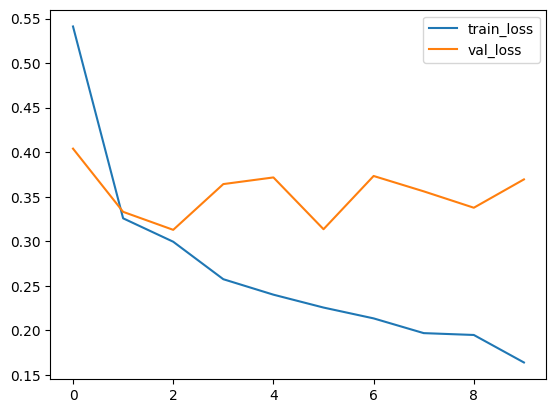

In [ ]:
# plotting the loss
import matplotlib.pyplot as plt
plt.plot(trained_model.history['loss'],label = 'train_loss')
plt.plot(trained_model.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

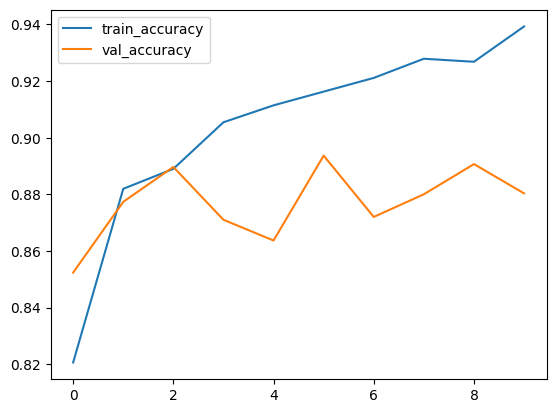

In [ ]:
# plotting the accuracy
import matplotlib.pyplot as plt
plt.plot(trained_model.history['accuracy'],label = 'train_accuracy')
plt.plot(trained_model.history['val_accuracy'],label = 'val_accuracy')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_set)

94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - accuracy: 0.8785 - loss: 0.3464


[0.3695305585861206, 0.8803333044052124]

In [ ]:
# saving the model
from tensorflow.keras.models import load_model
model.save('trained_vgg16.h5')

In [ ]:
model.predict(test_set)

94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step


array([[6.02466969e-07, 3.53031319e-05, 2.54538991e-05, 1.04518156e-04,
        9.99828577e-01, 5.43960596e-06],
       [2.16525518e-06, 2.21807767e-07, 9.21631813e-01, 7.83035904e-02,
        5.92326833e-05, 2.92270852e-06],
       [1.44799026e-06, 8.07045086e-04, 9.81848501e-03, 8.13097715e-01,
        1.76274940e-01, 3.92789900e-07],
       ...,
       [1.73507779e-05, 9.99516487e-01, 9.18673686e-06, 5.30466139e-07,
        3.06989762e-07, 4.56071401e-04],
       [1.39921297e-09, 9.99999881e-01, 1.22188784e-08, 1.23521512e-10,
        9.18298604e-10, 1.25137788e-07],
       [1.13920760e-04, 1.47504572e-04, 2.21697660e-03, 9.89492774e-01,
        8.00312031e-03, 2.57114334e-05]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image


In [ ]:
img = image.load_img('/content/drive/MyDrive/computerVision/seg_pred/seg_pred/10004.jpg',target_size = (224,224))

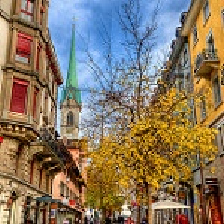

In [ ]:
img

In [ ]:
img_matrix = image.img_to_array(img)

In [ ]:
# scaling /normalizing
img_matrix = img_matrix/255.0


In [ ]:
from keras.applications.vgg16 import preprocess_input


In [ ]:
import numpy as np
img_matrix = np.expand_dims(img_matrix,axis = 0)
img_data = preprocess_input(img_matrix)

In [ ]:
print(img_data.shape)
print(training_set.target_size)
# training_set.shape
# img_data.shape

(1, 224, 224, 3)
(224, 224)


In [ ]:
model.predict(img_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


array([[8.8114393e-06, 5.8898980e-21, 4.0316990e-09, 7.7782128e-13,
        1.3733324e-08, 9.9999118e-01]], dtype=float32)

In [ ]:
result = np.argmax(model.predict(img_data),axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [ ]:
result

array([5])

In [ ]:
result[0]

np.int64(5)

In [ ]:
if result[0] ==1:
  prediction = 'forest'
  print(prediction)
elif result[0]==2:
  prediction = 'glacier'
  print(prediction)
elif result ==3:
  prediction = 'mountain'
  print(prediction)
elif result ==4:
  prediction = 'sea'
  print(prediction)
elif result ==5:
  prediction = 'street'
  print(prediction)
else:
  prediction = 'buildings'
  print(prediction)

street
